In [96]:
import sys
sys.path.append('/kaggle/input/required8')
import matplotlib
matplotlib.use('Agg') 
from scipy.stats import entropy
from numpy.linalg import norm
from matplotlib.ticker import FuncFormatter
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pylab
import os
import matplotlib.pyplot as plt

class AEDetector:
    def __init__(self, model_class, model_path, p=1, device='cpu',model_kwargs=None):
        """
        Error-based detector.

        model_class: The class of the AE model (e.g., DenoisingAutoEncoder).
        model_path: Path to the model's saved state_dict (.pth).
        p: Power for error norm (e.g., 1 = L1, 2 = L2).
        device: torch.device object or string ("cuda" / "cpu").
        """
        self.device = device 
        self.model = model_class(**(model_kwargs or {})).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        self.p = p
        
    def mark(self, X):
        """
        X: A PyTorch tensor of shape [N, C, H, W] on CPU or GPU.
        Returns: 1D numpy array of anomaly scores (reconstruction errors).
        """
        self.model.eval()

        with torch.no_grad():
            if X.ndim == 4 and X.shape[1:] == torch.Size([28, 28, 1]):
                
                X = X.permute(0, 3, 1, 2)

            X = X.to(self.device)
            recon = self.model(X)
            diff = torch.abs(X - recon)  # Absolute error
            score = torch.mean(torch.pow(diff, self.p), dim=[1, 2, 3])  # Per-sample score
            return score.cpu().numpy()  # Convert to NumPy for compatibility

    def print(self):
        return "AEDetector:" + os.path.basename(self.path)


class IdReformer:
    def __init__(self, device=None):
        """
        Improved identity reformer with device handling
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def heal(self, X):
        """Maintain device consistency"""
        return X.to(self.device)

    def print(self):
        return f"IdReformer(device={self.device})"


class SimpleReformer:
    def __init__(self, model_class, model_path, device='cpu', model_kwargs=None):
        """
        Autoencoder-based reformer. Applies reconstruction (healing).

        model_class: Class definition of the autoencoder.
        path: Path to the saved model (.pth).
        device: torch.device or str ("cuda" or "cpu").
        """
        self.device = device 
        self.model = model_class(**(model_kwargs or {})).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        self.image_shape = self.model.image_shape
        self.path = model_path

    def heal(self, X):
        """
        X: Tensor [N, C, H, W] (should be on same device as model)
        Returns: Reconstructed input clipped between 0 and 1 (as Torch Tensor)
        """
        self.model.eval()
        with torch.no_grad():
            X = X.to(self.device)
            if X.ndim == 3:  # Single image
                if X.shape[-1] == 1:  # HWC format
                    X = X.permute(2, 0, 1).unsqueeze(0)  # Convert to NCHW
                else:  # CHW format
                    X = X.unsqueeze(0)  # Add batch dimension
            elif X.ndim == 4:  # Batch of images
                if X.shape[-1] == 1:  # NHWC format
                    X = X.permute(0, 3, 1, 2)  # Convert to NCHW
        
       
            recon = self.model(X)
            recon = torch.clamp(recon, 0.0, 1.0)
            return recon.cpu()

    def print(self):
        return "SimpleReformer:" + os.path.basename(self.path)


def JSD(P, Q):
    """
    Jensen-Shannon Divergence between two 1D arrays (P, Q).
    P, Q: Numpy arrays representing discrete distributions.
    """
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))


class DBDetector:
    def __init__(self, reconstructor, prober, classifier, option="jsd", T=1):
        """
        Divergence-Based Detector using PyTorch.

        reconstructor: One reformer (e.g., SimpleReformer instance).
        prober: Another reformer (same type).
        classifier: Classifier object with classify() method.
        option: Distance measure to use, default is 'jsd'.
        T: Temperature for softmax (scaling logits).
        """
        self.prober = prober
        self.reconstructor = reconstructor
        self.classifier = classifier
        self.option = option
        self.T = T

    def mark(self, X):
        if self.option == "jsd":
            return self.mark_jsd(X)
        else:
            raise NotImplementedError(f"Only 'jsd' is implemented, got {self.option}")

    def mark_jsd(self, X):
        """
        Returns JSD divergence between classifier outputs on
        probed and reconstructed samples.
        
        X: Input tensor [N, C, H, W] (torch.Tensor)
        """
        Xp = self.prober.heal(X)
        Xr = self.reconstructor.heal(X)

        Pp = self.classifier.classify(Xp, option="prob", T=self.T)  # numpy array [N, num_classes]
        Pr = self.classifier.classify(Xr, option="prob", T=self.T)

        marks = [JSD(Pp[i], Pr[i]) for i in range(len(Pr))]
        return np.array(marks)

    def print(self):
        return "Divergence-Based Detector"



class Classifier:
    def __init__(self, model_class, classifier_path, device='cpu', model_kwargs=None):
        """
        PyTorch classifier wrapper. Assumes the model outputs raw logits.

        model_class: A callable (e.g., a class or lambda) that returns the classifier architecture.
        classifier_path: Path to saved model weights (.pth).
        device: torch.device or string ("cuda"/"cpu"). Auto-detected if not provided.
        model_kwargs: dict of kwargs for model_class constructor
        """
        self.path = classifier_path
        self.device = device 

        self.model = model_class(**(model_kwargs or {})).to(self.device)
        self.model.load_state_dict(torch.load(classifier_path, map_location=self.device))
        self.model.eval()

    def classify(self, X, option="logit", T=1):
        """
        Classify input.

        X: Torch tensor [N, C, H, W]
        option: "logit" to return raw logits, "prob" to return softmax probs.
        T: Temperature (used only with option="prob")
        Returns: NumPy array
        """
        if X.ndim == 4 and X.shape[1:] == torch.Size([28, 28, 1]):
            X = X.permute(0, 3, 1, 2)
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.from_numpy(X).float()

            X = X.to(self.device)
            logits = self.model(X)

            if option == "logit":
                return logits.cpu().numpy()

            elif option == "prob":
                probs = F.softmax(logits / T, dim=1)
                return probs.cpu().numpy()

            else:
                raise ValueError(f"Invalid option: {option}. Use 'logit' or 'prob'.")

    def print(self):
        return "Classifier:" + os.path.basename(self.path)


class Operator:
    def __init__(self, data, classifier, det_dict, reformer):
        """
        Operator that wraps the data, classifier, detector(s), and reformer logic.

        data: MNIST object with .train_loader, .validation_loader, .test_loader
        classifier: Classifier object (must have .classify(X) method)
        det_dict: Dictionary of detectors, each with .mark(X)
        reformer: Reformer object (must have .heal(X))
        """
        self.data = data
        self.classifier = classifier
        self.det_dict = det_dict
        self.reformer = reformer

        test_imgs = torch.stack([img for img, _ in data.test_data])
        test_labels = torch.tensor([label for _, label in data.test_data])
        self.normal = self.operate(AttackData(test_imgs, test_labels, "Normal"))

    def get_thrs(self, drop_rate):
        """
        Calculates thresholds for filtering from validation set.
        drop_rate: Dict mapping detector names to float drop rates.
        """
        thrs = {}
        val_imgs = torch.stack([img for img, _ in self.data.validation_data])
        for name, detector in self.det_dict.items():
            num = int(len(val_imgs) * drop_rate[name])
            marks = detector.mark(val_imgs)
            sorted_marks = np.sort(marks)
            thrs[name] = sorted_marks[-num]
        return thrs

    def operate(self, untrusted_obj):
        """
        Classifies original and reformed inputs using the classifier.
        Returns: Array of (original_correct, reformed_correct) pairs.
        """
        device = next(self.classifier.model.parameters()).device
        X = untrusted_obj.data.to(device)
        Y_true = untrusted_obj.labels.to(device)

        with torch.no_grad():
            X_prime = self.reformer.heal(X)
            Y_pred = torch.tensor(np.argmax(self.classifier.classify(X), axis=1))
            Y_judgement = (Y_pred == Y_true[:len(X_prime)])

            Yp_pred = torch.tensor(np.argmax(self.classifier.classify(X_prime), axis=1))
            Yp_judgement = (Yp_pred == Y_true[:len(X_prime)])

        return np.array(list(zip(Y_judgement.cpu().numpy(), Yp_judgement.cpu().numpy())))

    def filter(self, X, thrs):
        """
        Filters inputs using detector thresholds.
        Returns indices that passed all filters.
        """
        all_pass = np.arange(X.shape[0])
        collector = {}

        for name, detector in self.det_dict.items():
            marks = detector.mark(X)
            idx_pass = np.argwhere(marks < thrs[name]).flatten()
            collector[name] = len(idx_pass)
            all_pass = np.intersect1d(all_pass, idx_pass)

        return all_pass, collector

    def print(self):
        components = [self.reformer, self.classifier]
        return " ".join(obj.print() for obj in components)



class Evaluator:
    def __init__(self, operator, untrusted_data, graph_dir="/kaggle/working/graphs/"):
        """
        Evaluator for analyzing the defense strategy.

        operator: Operator object.
        untrusted_data: Adversarial or noisy test dataset wrapped in AttackData.
        graph_dir: Path to save graphs.
        """
        self.operator = operator
        self.untrusted_data = self.normalize_attack_data(untrusted_data)
        self.graph_dir = graph_dir
        self.data_package = operator.operate(untrusted_data)

    def normalize_attack_data(self, data):
        """Normalize AttackData images"""
        device = next(self.operator.classifier.model.parameters()).device
        normalized_images = normalize_mnist(data.data.to(device))
        return AttackData(normalized_images, data.labels.to(device), data.name)


    def bind_operator(self, operator):
        """
        Replace current operator and re-evaluate.
        """
        self.operator = operator
        self.data_package = operator.operate(self.untrusted_data)

    def load_data(self, data):
        """
        Replace current untrusted data and re-evaluate.
        """
        self.untrusted_data = data
        self.data_package = self.operator.operate(self.untrusted_data)

    def get_normal_acc(self, normal_all_pass):
        """
        Measure classification accuracy on clean data after filtering.

        Returns:
        - both_acc: Accuracy when both detector and reformer pass.
        - det_only_acc: Accuracy with just detector.
        - ref_only_acc: Accuracy with just reformer.
        - none_acc: Accuracy without any defense.
        """
        normal_tups = self.operator.normal
        num_normal = len(normal_tups)
        filtered_normal_tups = normal_tups[normal_all_pass]

        both_acc = sum(1 for _, XpC in filtered_normal_tups if XpC) / num_normal
        det_only_acc = sum(1 for XC, _ in filtered_normal_tups if XC) / num_normal
        ref_only_acc = sum(1 for _, XpC in normal_tups if XpC) / num_normal
        none_acc = sum(1 for XC, _ in normal_tups if XC) / num_normal

        return both_acc, det_only_acc, ref_only_acc, none_acc

    def get_attack_acc(self, attack_pass):
        """
        Measure classification accuracy on adversarial data.

        Returns same metrics as get_normal_acc.
        """
        attack_tups = self.data_package
        num_untrusted = len(attack_tups)
        filtered_attack_tups = attack_tups[attack_pass]

        both_acc = 1 - sum(1 for _, XpC in filtered_attack_tups if not XpC) / num_untrusted
        det_only_acc = 1 - sum(1 for XC, _ in filtered_attack_tups if not XC) / num_untrusted
        ref_only_acc = sum(1 for _, XpC in attack_tups if XpC) / num_untrusted
        none_acc = sum(1 for XC, _ in attack_tups if XC) / num_untrusted

        return both_acc, det_only_acc, ref_only_acc, none_acc



   

    def plot_epsilon_sweep(self, graph_name, drop_rate, epsilons, 
                          attack_type="fgsm", data_dir='/kaggle/working/attack_data/'):
        """Plots defense performance across different attack strengths (epsilons)"""
        pylab.rcParams['figure.figsize'] = 10, 6
        fig = plt.figure()
        device = next(self.operator.classifier.model.parameters()).device
        
        # Initialize storage for metrics
        metrics = {
            'both': [],
            'det_only': [],
            'ref_only': [],
            'none': []
        }
        
        # Calculate dynamic thresholds
        thrs = {
            "I": 1.5,
            "II":1.5
        }
        
        for eps in epsilons:
            # Load attack data
            attack_name = f"{attack_type}_{eps}"
            attack_data = load_obj(f"{attack_name}_attack", data_dir).to(device)
            attack_labels = load_obj(f"{attack_name}_labels", data_dir).to(device)
            
            # Normalize and process
            attack_data = normalize_mnist(attack_data)
            attack_dataset = AttackData(attack_data, attack_labels, name=attack_name)
            self.load_data(attack_dataset)
            
            # Get accuracy metrics
            attack_pass, _ = self.operator.filter(attack_dataset.data, thrs)
            total_images = len(attack_dataset.data)
            passed_images = len(attack_pass)  # If attack_pass is indices
        # OR if attack_pass is boolean mask: passed_images = sum(attack_pass)
        
            print(f"ε={eps}: {passed_images}/{total_images} ({passed_images/total_images:.1%}) images passed detector")
            accs = self.get_attack_acc(attack_pass)
            
            # Store results
            metrics['both'].append(accs[0])
            metrics['det_only'].append(accs[1])
            metrics['ref_only'].append(accs[2])
            metrics['none'].append(accs[3])
        
        # Plot results
        plt.plot(epsilons, metrics['both'], 'b-o', label="Both Defense")
        plt.plot(epsilons, metrics['det_only'], 'g-s', label="Detector Only")
        plt.plot(epsilons, metrics['ref_only'], 'r-^', label="Reformer Only")
        plt.plot(epsilons, metrics['none'], 'k-x', label="No Defense")
        
        plt.xlabel("Attack Strength (ε)")
        plt.ylabel("Classification Accuracy")
        plt.title("Defense Performance vs FGSM Attack Strength")
        plt.legend()
        plt.grid(True)
        
        # Save plot
        graph_path = os.path.join(self.graph_dir, graph_name + ".png")
        os.makedirs(self.graph_dir, exist_ok=True)
        plt.savefig(graph_path)
        plt.close(fig)
    
   

In [97]:
import pickle
import os
class AttackData:
    def __init__(self, data, labels, name="",directory="/kaggle/input/required8"):
        """
        Wrapper for input data (normal or adversarial).
        
        examples: Tensor or path to saved object.
        labels: Tensor or numpy array of ground truth labels.
        name: Identifier string.
        """
        if not isinstance(data, torch.Tensor):
            self.data = torch.tensor(data)
        else:
            self.data = data
            
        if not isinstance(labels, torch.Tensor):
            self.labels = torch.tensor(labels)
        else:
            self.labels = labels
            
        self.name = name
        self.length = len(self.data)

    def print(self):
        return "Attack:" + self.name


def normalize_mnist(images):
    mean = torch.tensor([0.1307], device=images.device)
    std = torch.tensor([0.3081], device=images.device)
    return (images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)



def prepare_data(dataset, idx):
    """
    Extracts image and label data at specific indices from the test set.

    dataset: Instance of MNIST() class.
    idx: List or tensor of indices into the test set.
    Returns:
        X: torch.Tensor of images [N, 1, 28, 28]
        targets: torch.Tensor of integer labels [N]
        Y: Same as targets (for compatibility with original code using argmax)
    """
    # dataset.test_data is a torchvision.datasets.MNIST object
    images = []
    labels = []
    for i in idx:
        img, label = dataset.test_data[i]
        images.append(img)
        labels.append(label)

    X = torch.stack(images)  # shape: [N, 1, 28, 28]
    targets = torch.tensor(labels, dtype=torch.long)  # shape: [N]
    Y = targets.clone()  # No one-hot, so argmax would just return same

    return X, targets, Y


def save_obj(obj, name, directory='./attack_data/'):
    os.makedirs(directory, exist_ok=True)
    with open(os.path.join(directory, name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name, directory='./attack_data/'):
    if name.endswith(".pkl"):
        name = name[:-4]
    with open(os.path.join(directory, name + '.pkl'), 'rb') as f:
        return pickle.load(f)

    if isinstance(data, (np.ndarray, memoryview)):
        data = torch.tensor(np.array(data))
    elif isinstance(data, list):
        data = torch.stack([torch.tensor(x) for x in data])
    
    return data


def generate_attack_data(model, attack_type, epsilon, steps=10, num_samples=1000):
    """
    Generate adversarial examples using FGSM/PGD
    Returns: AttackData object containing adversarial examples
    """
    # Get clean samples
    idx = torch.randperm(len(dataset.test_data))[:num_samples]
    X_clean, targets, Y = prepare_data(dataset, idx)
    
    # Initialize attack
    if attack_type.lower() == "fgsm":
        attacker = FGSMAttack(model, epsilon=epsilon)
    elif attack_type.lower() == "pgd":
        attacker = PGDAttack(model, eps=epsilon, alpha=epsilon/4, steps=steps)
    else:
        raise ValueError(f"Unsupported attack type: {attack_type}")

    # Generate adversarial examples
    X_adv = attacker.generate(X_clean, targets)
    
    return AttackData(X_adv, targets, name=f"{attack_type.upper()}_eps_{epsilon}")



In [98]:
class FGSMAttack:
    def __init__(self, model, epsilon=0.2):
        self.model = model
        self.epsilon = epsilon
        self.device = next(model.parameters()).device
        
    def generate(self, images, labels):
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        images.requires_grad = True
        
        outputs = self.model(images)
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        
        self.model.zero_grad()
        loss.backward()
        
        perturbation = self.epsilon * images.grad.data.sign()
        perturbed_images = torch.clamp(images + perturbation, 0, 1).detach()
        
        return perturbed_images

class PGDAttack:
    def __init__(self, model, eps=0.1, alpha=0.01, steps=10):
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.device = next(model.parameters()).device
        
    def generate(self, images, labels):
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        
        delta = torch.empty_like(images).uniform_(-self.eps, self.eps)
        adv_images = torch.clamp(images + delta, 0, 1).detach()
        
        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.model(adv_images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            
            self.model.zero_grad()
            loss.backward()
            
            grad = adv_images.grad.detach()
            delta = adv_images - images + self.alpha * grad.sign()
            delta = torch.clamp(delta, -self.eps, self.eps)
            adv_images = torch.clamp(images + delta, 0, 1).detach()
            
        return adv_images

In [99]:
import sys
sys.path.append('/kaggle/input/required8')
import torch
from dataloader import MNIST
from utils import prepare_data, load_obj
from DAE_model import DenoisingAutoEncoder
from model import CNNClassifier



# ---- Load models ----
detector_I = AEDetector(DenoisingAutoEncoder, "/kaggle/input/required8/MNIST_I.pth", p=2, model_kwargs={'image_shape': (1, 28, 28), 'structure': [3,"average",3], 'v_noise': 0.1, 'activation': 'relu', 'model_dir': './defensive_models/', 'reg_strength': 0.0})
detector_II = AEDetector(DenoisingAutoEncoder, "/kaggle/input/required8/MNIST_II.pth", p=1, model_kwargs={'image_shape': (1, 28, 28), 'structure': [3], 'v_noise': 0.1, 'activation': 'relu', 'model_dir': './defensive_models/', 'reg_strength': 0.0})
reformer = SimpleReformer(DenoisingAutoEncoder, "/kaggle/input/required8/MNIST_I.pth", model_kwargs={'image_shape': (1, 28, 28), 'structure': [3,"average",3], 'v_noise': 0.1, 'activation': 'relu', 'model_dir' : './defensive_models/', 'reg_strength': 0.0})
"""idreformer = IdReformer(device=next(classifier.model.parameters()).device)"""
classifier = Classifier(CNNClassifier, "/kaggle/input/required8/example_classifier.pth",model_kwargs={'params' : [32,32,64,64,200,200]})

# ---- Compose detector dictionary ----
detector_dict = {
    "I": detector_I,
    "II": detector_II
}

# ---- Load MNIST data ----
dataset = MNIST()
operator = Operator(dataset, classifier, detector_dict, reformer)

SAVE_DIR = '/kaggle/working/attack_data/'
os.makedirs(SAVE_DIR, exist_ok=True)

# Generate 1000 random indices
idx = torch.randperm(len(dataset.test_data))[:1000]
X_clean, targets, Y = prepare_data(dataset, idx)
X_clean = normalize_mnist(X_clean)

epsilons = [0.01, 0.05, 0.1, 0.2, 0.5]
# Generate attacks
for eps in epsilons:
    fgsm_attack = generate_attack_data(classifier.model, "fgsm", eps, num_samples=1000)
    save_obj(fgsm_attack.data.cpu(), f"fgsm_{eps}_attack", directory=SAVE_DIR)
    save_obj(fgsm_attack.labels.cpu(), f"fgsm_{eps}_labels", directory=SAVE_DIR)



# Evaluation
LOAD_DIR = '/kaggle/working/attack_data/'
device = next(classifier.model.parameters()).device
def load_and_normalize_attack(attack_name):
    images = load_obj(f"{attack_name}_attack", LOAD_DIR).to(device)
    labels = load_obj(f"{attack_name}_labels", LOAD_DIR).to(device)
    return AttackData(normalize_mnist(images), labels, name=attack_name)





initial_attack = load_and_normalize_attack("fgsm_0.1")
evaluator = Evaluator(operator, initial_attack)

# Call the epsilon sweep plot
evaluator.plot_epsilon_sweep(
    epsilons=[0.01, 0.05, 0.1, 0.2, 0.5],
    drop_rate={"I": 0.1, "II": 0.1},
    graph_name="fgsm_epsilon_comparison"
)



ε=0.01: 956/1000 (95.6%) images passed detector
ε=0.05: 972/1000 (97.2%) images passed detector
ε=0.1: 979/1000 (97.9%) images passed detector
ε=0.2: 994/1000 (99.4%) images passed detector
ε=0.5: 1000/1000 (100.0%) images passed detector


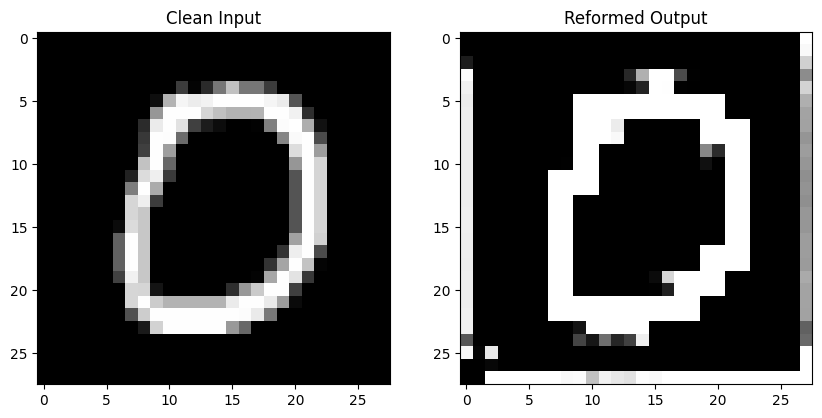

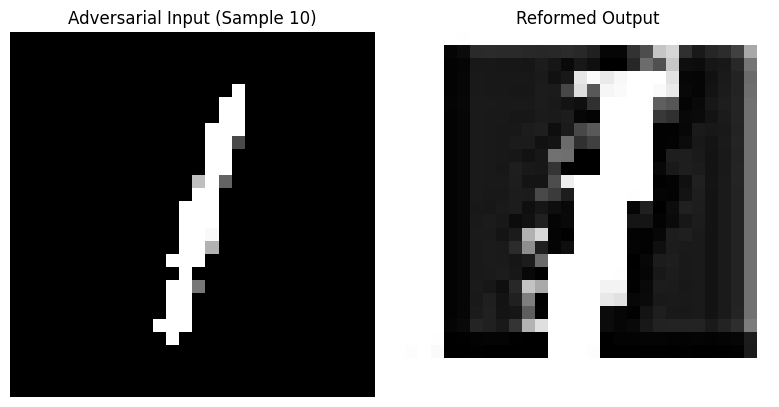

In [100]:
%matplotlib inline
clean_img = dataset.test_data[10][0].unsqueeze(0).to(reformer.device)  # Shape: [1, 1, 28, 28]
reformed = reformer.heal(clean_img)
plt.subplot(1,2,1); plt.imshow(clean_img.cpu().squeeze(), cmap='gray')
plt.title("Clean Input")
plt.subplot(1,2,2); plt.imshow(reformed.cpu().squeeze(), cmap='gray')
plt.title("Reformed Output")
plt.show()

device = next(classifier.model.parameters()).device
sample_idx = 10
# Load and convert adversarial data
adv_imgs = load_obj("fgsm_attack", directory='/kaggle/working/attack_data/')
adv_labels = load_obj("fgsm_labels", directory='/kaggle/working/attack_data/')

# Convert to tensors and move to device
adv_imgs = adv_imgs.to(device) if isinstance(adv_imgs, torch.Tensor) else torch.tensor(adv_imgs).to(device)
adv_labels = adv_labels.to(device) if isinstance(adv_labels, torch.Tensor) else torch.tensor(adv_labels).to(device)
adv_imgs = normalize_mnist(adv_imgs)
adv_sample = adv_imgs[sample_idx].unsqueeze(0)  # [1,1,28,28]
reformed_sample = reformer.heal(adv_sample)


adv_display = adv_sample.cpu().squeeze()
reformed_display = reformed_sample.cpu().squeeze()
difference = (adv_display - reformed_display).abs()

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(adv_display, cmap='gray', vmin=0, vmax=1)
plt.title(f"Adversarial Input (Sample {sample_idx})")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reformed_display, cmap='gray', vmin=0, vmax=1)
plt.title("Reformed Output")
plt.axis('off')



plt.tight_layout()
plt.show()

In [101]:
def normalize_mnist(images):
    mean = torch.tensor([0.1307], device=images.device)
    std = torch.tensor([0.3081], device=images.device)
    return (images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

device = next(classifier.model.parameters()).device

# Load and convert adversarial data
adv_imgs = load_obj("fgsm_attack", directory='/kaggle/working/attack_data/')
adv_labels = load_obj("fgsm_labels", directory='/kaggle/working/attack_data/')

# Convert to tensors and move to device
adv_imgs = adv_imgs.to(device) if isinstance(adv_imgs, torch.Tensor) else torch.tensor(adv_imgs).to(device)
adv_labels = adv_labels.to(device) if isinstance(adv_labels, torch.Tensor) else torch.tensor(adv_labels).to(device)
adv_imgs = normalize_mnist(adv_imgs)

# Apply reformer (ensure it outputs to device)
reformed_adv = reformer.heal(adv_imgs).to(device)  # Remove .cpu() in reformer.heal()

# Get predictions
with torch.no_grad():
    preds_before = classifier.model(adv_imgs).argmax(dim=1)
    preds_after = classifier.model(reformed_adv).argmax(dim=1)

# Calculate accuracy
adv_accuracy_before = (preds_before == adv_labels).float().mean().item()
adv_accuracy_after = (preds_after == adv_labels).float().mean().item()

_, test_labels = next(iter(dataset.test_loader))  # Get batch of normal data
test_imgs, test_labels = next(iter(dataset.test_loader))
test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
test_imgs = normalize_mnist(test_imgs)
# Apply reformer
reformed_normal = reformer.heal(test_imgs)

# Get predictions
with torch.no_grad():
    normal_preds_before = classifier.model(test_imgs).argmax(dim=1)
    normal_preds_after = classifier.model(reformed_normal).argmax(dim=1)

# Calculate normal accuracy
normal_accuracy_before = (normal_preds_before == test_labels).float().mean().item()
normal_accuracy_after = (normal_preds_after == test_labels).float().mean().item()

# ===== Print Results =====
print("Adversarial Images:")
print(f"Accuracy before reforming: {adv_accuracy_before:.2%}")
print(f"Accuracy after reforming: {adv_accuracy_after:.2%}\n")

print("Normal Images:")
print(f"Accuracy before reforming: {normal_accuracy_before:.2%}")
print(f"Accuracy after reforming: {normal_accuracy_after:.2%}")

Adversarial Images:
Accuracy before reforming: 93.20%
Accuracy after reforming: 69.00%

Normal Images:
Accuracy before reforming: 100.00%
Accuracy after reforming: 78.12%
